## This notebook includes:

#### 1) Create and train RNN models 
#### 2) Tuning Theta of Gradient Clipping
#### 2) Concise implementation of RNN
#### 4) Long-Short Term Memory

# 1. Train Recurrent Neural Networks from Scratch

In [1]:
!pip install d2l==0.16.2
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.9 MB/s eta 0:00:00


In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## One-Hot Encoding

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## Initializing the Model Parameters

In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

In [6]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [7]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [8]:
class RNNModelScratch: 
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [10]:
def predict_ch8(prefix, num_preds, net, vocab, device): 
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [11]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller oemqzgskxj'

## Gradient Clipping

For a sequence of length $T$,
we compute the gradients over these $T$ time steps in an iteration, which results in a chain of matrix-products with length  $\mathcal{O}(T)$ during backpropagation.
As mentioned in :numref:`sec_numerical_stability`, it might result in numerical instability, e.g., the gradients may either explode or vanish, when $T$ is large. Therefore, RNN models often need extra help to stabilize the training.

Generally speaking,
when solving an optimization problem,
we take update steps for the model parameter,
say in the vector form
$\mathbf{x}$,
in the direction of the negative gradient $\mathbf{g}$ on a minibatch.
For example,
with $\eta > 0$ as the learning rate,
in one iteration we update
$\mathbf{x}$
as $\mathbf{x} - \eta \mathbf{g}$.
Let us further assume that the objective function $f$
is well behaved, say, *Lipschitz continuous* with constant $L$.
That is to say,
for any $\mathbf{x}$ and $\mathbf{y}$ we have

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

In this case we can safely assume that if we update the parameter vector by $\eta \mathbf{g}$, then

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$

which means that
we will not observe a change by more than $L \eta \|\mathbf{g}\|$. This is both a curse and a blessing.
On the curse side,
it limits the speed of making progress;
whereas on the blessing side,
it limits the extent to which things can go wrong if we move in the wrong direction.

Sometimes the gradients can be quite large and the optimization algorithm may fail to converge. We could address this by reducing the learning rate $\eta$. But what if we only *rarely* get large gradients? In this case such an approach may appear entirely unwarranted. One popular alternative is to clip the gradient $\mathbf{g}$ by projecting them back to a ball of a given radius, say $\theta$ via

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$

By doing so we know that the gradient norm never exceeds $\theta$ and that the
updated gradient is entirely aligned with the original direction of $\mathbf{g}$.
It also has the desirable side-effect of limiting the influence any given
minibatch (and within it any given sample) can exert on the parameter vector. This
bestows a certain degree of robustness to the model. Gradient clipping provides
a quick fix to the gradient exploding. While it does not entirely solve the problem, it is one of the many techniques to alleviate it.

Below we define a function to clip the gradients of
a model that is implemented from scratch or a model constructed by the high-level APIs.
Also note that we compute the gradient norm over all the model parameters.


In [12]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training


In [13]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter, theta):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, theta)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [14]:

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False, theta = 1):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter, theta = theta)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.0, 89887.3 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


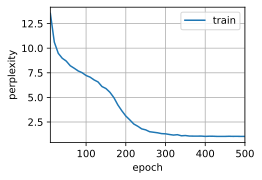

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), theta = 1)

perplexity 1.5, 61606.0 tokens/sec on cuda:0
time traveller proceeded the time travellerit s against reason s
travellerit s against reason said filbywhat very cunnotse t


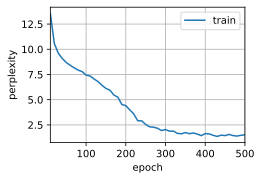

In [16]:
net2 = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net2, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

# 2. Tuning theta of grad_clipping from values \{0.1, 10\} respectively and re-train the RNN.

perplexity 1.0, 96736.5 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


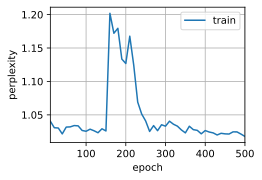

In [17]:
theta = 0.1 
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), theta = theta)

perplexity 1.0, 100923.2 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


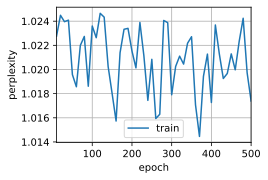

In [18]:
theta = 10
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), theta = theta)

# 3. Concise Implementation of Recurrent Neural Networks



In [19]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## Defining the Model

In [20]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

We use a tensor to initialize the hidden state,
whose shape is
(number of hidden layers, batch size, number of hidden units).


In [21]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [22]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [23]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

## Training and Predicting

Before training the model, let us make a prediction with the a model that has random weights.


In [24]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time traveller<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>'

perplexity 1.3, 529346.6 tokens/sec on cuda:0
time traveller pame bat someptiove tamantar vark at whali ged an
traveller astel gan said the medical man andfilby becamt th


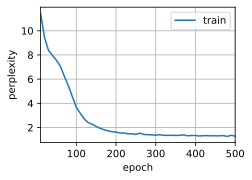

In [25]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# 4. Long Short-Term Memory (LSTM)

In [26]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Initializing Model Parameters

In [27]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate memory cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### Defining the Model


In [28]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [29]:
def lstm(inputs, state, params):
    [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### Training and Prediction

perplexity 1.1, 30013.0 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


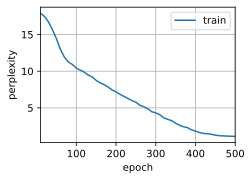

In [30]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Concise Implementation

perplexity 1.0, 271833.4 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


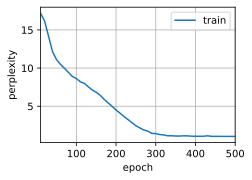

In [31]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Implement multiple layers at a single LSTM unit

perplexity 1.0, 255078.5 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


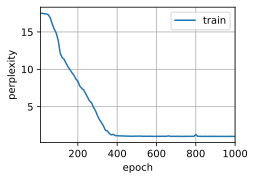

In [32]:
num_epochs = 1000
lstm_layer = nn.LSTM(num_inputs, num_hiddens, 2)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

